Top best selling products (by product_name):
['Red Stone  ', 'Ruby  ', 'The Moonstone  ', 'The Sapphires  ', 'Ruby Sparks  ', 'Aquamarine  ', 'Ruby Bridges  ', 'Sapphire  ', 'GUESS "Basic" Gold 7 Piece Mixed Bangle Bracelet  ', "AtPerry's 16 Natural Healing Crystals Set in Wooden Box - Tumbled, Rough & Raw Crystals, Including Selenite Tower, Black Tourmaline, Amethyst, Rose Quartz, Lapiz Lazuli, Citrine & Tiger's Eye  "]
Top meaningful keywords in best selling product names:
[('ruby', 3), ('red', 1), ('moonstone', 1), ('sapphires', 1), ('sparks', 1), ('aquamarine', 1), ('bridges', 1), ('sapphire', 1), ('basic', 1), ('gold', 1)]

Unique meaningful keywords in customer reviews by sentiment:
Positive: [('compliments', 101), ('meditation', 81), ('enjoy', 71), ('packed', 60), ('helpful', 52), ('bonus', 52), ('hr', 50), ('middle', 48), ('bring', 47), ('elegant', 44)]
Negative: [('shakra', 9), ('abuse', 8), ('disgusted', 7), ('scenes', 6), ('lapas', 6), ('inferior', 5), ('disgusting', 5), ('t

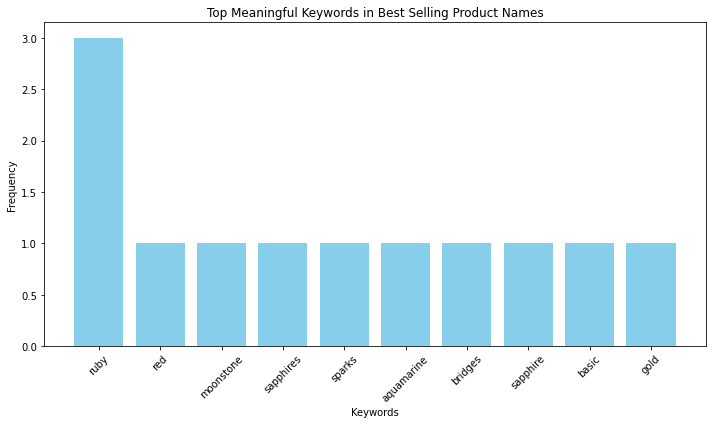

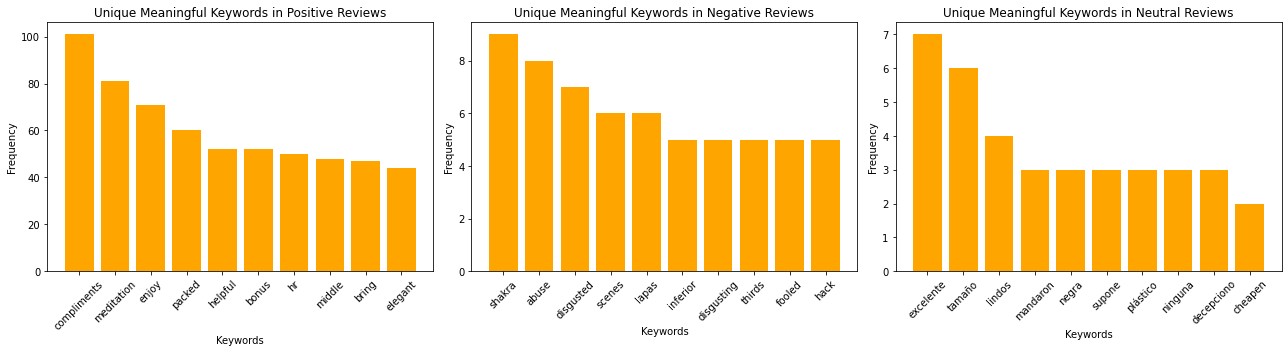

In [27]:
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer


# Download required NLTK resources 
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('vader_lexicon')

# Load the dataset 
df = pd.read_csv('merged_data.csv')

#remove unrelated products
exclude_products = [
    "Ruby Herring Mysteries: Prediction Murder",
    "Ruby: A Novel (Oprahs Book Club 2.0)",
    "VC Andrews' Ruby  ",
    "Happy Birthday, Marsha!  ",
    "The Moonstone, Season 1  ",
    "Ruby Herring Mysteries: Prediction Murder  ",
    "Max & Ruby Seasons 1 & 2  ",
    "The Dark Crystal (4K UHD)  ",
    "Rock Paradise 1 (ONE) Large Black Tourmaline Rod with Mica Inclusions - Powerful Energy - Over 1/2 lb from Brazil Exclusive COA  ",
    "Garmin fenix 6X Sapphire, Premium Multisport GPS Watch, features Mapping, Music, Grade-Adjusted Pace Guidance and Pulse Ox Sensors, Dark Gray with Black Band"
]
df = df[~df['Product_name'].isin(exclude_products)] 

# Define stopwords and include "crystal" and "crystals"
stop_words = set(stopwords.words('english'))
stop_words.update(["crystal", "crystals","stone","stones","guess","gusto","mismo","bien",'gustó', 'puso','bastante','están'])

# Function to clean and tokenize text: lowercases, removes punctuation and stopwords.
def extract_tokens(text):
    text = text.lower()
    text = re.sub(r'[\W_]+', ' ', text)
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words and len(token) > 1]
    return tokens

#########################################
# Part 1: Top Meaningful Keywords from Product Names
#########################################
# Define best selling products as those with the highest sum of:
# 1. The number of reviews (i.e., count of rows for that product) 
# 2. The unique count_of_rating value (each product has the same value for this column)

# Group by product_name. For each product, count the reviews and get the count_of_rating value once.
product_groups = df.groupby('Product_name').agg(
    review_count=('Review_Body', 'count'),
    rating_value=('Count_of_Rating', 'first')  # since the value is the same across rows
).reset_index()

# Compute best selling score = review_count + rating_value
product_groups['best_selling_score'] = product_groups['review_count'] + pd.to_numeric(product_groups['rating_value'], errors='coerce').astype('Int64')

# Sort products by best selling score and select top 10.
top_products = product_groups.sort_values('best_selling_score', ascending=False)['Product_name'].head(10).tolist()
print("Top best selling products (by product_name):")
print(top_products)

# Extract tokens from the names of these best selling products.
all_product_tokens = []
for name in top_products:
    tokens = extract_tokens(str(name))
    all_product_tokens.extend(tokens)

# Count token frequencies for product names.
product_keywords_counter = Counter(all_product_tokens)

# Get the top 10 meaningful keywords.
top_product_keywords = product_keywords_counter.most_common(10)
print("Top meaningful keywords in best selling product names:")
print(top_product_keywords)

##############################################
# Part 2: Sentiment Analysis & Unique Meaningful Keyword Extraction from Reviews
##############################################

# Initialize VADER sentiment analyzer.
sia = SentimentIntensityAnalyzer()

# Assume "review_text" is the column with customer review content.
# Compute compound sentiment score for each review.
df['sentiment_score'] = df['Review_Body'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

# Label sentiment based on compound score.
def label_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['sentiment_score'].apply(label_sentiment)

# Build frequency counters for tokens per sentiment.
sentiment_counters = {}
for sentiment in ['positive', 'negative', 'neutral']:
    reviews = df[df['sentiment'] == sentiment]['Review_Body'].dropna()
    tokens_all = []
    for review in reviews:
        tokens_all.extend(extract_tokens(review))
    sentiment_counters[sentiment] = Counter(tokens_all)

# Create a global token frequency counter from all reviews for common filtering.
all_review_tokens = []
for review in df['Review_Body'].dropna():
    all_review_tokens.extend(extract_tokens(review))
global_review_counter = Counter(all_review_tokens)
common_threshold_reviews = len(all_review_tokens) * 0.05  # 5% of total tokens in reviews

# For each sentiment, remove tokens that appear in the other sentiment groups,
# then filter out tokens that are too common globally.
unique_sentiment_keywords = {}
sentiments = ['positive', 'negative', 'neutral']
for sentiment in sentiments:
    # Tokens from the other two sentiments.
    other_sentiments = set(sentiments) - {sentiment}
    other_tokens = set()
    for other in other_sentiments:
        other_tokens |= set(sentiment_counters[other].keys())
    
    # Keep tokens unique to this sentiment.
    unique_counter = {word: count for word, count in sentiment_counters[sentiment].items() 
                        if word not in other_tokens}
    
    # Further filter out tokens that are too common globally.
    filtered_unique_counter = {word: count for word, count in unique_counter.items() 
                               if global_review_counter[word] < common_threshold_reviews}
    
    unique_sentiment_keywords[sentiment] = Counter(filtered_unique_counter).most_common(10)

print("\nUnique meaningful keywords in customer reviews by sentiment:")
for sentiment, keywords in unique_sentiment_keywords.items():
    print(f"{sentiment.capitalize()}: {keywords}")

##############################################
# Visualization Section
##############################################

# Visualization 1: Top Meaningful Keywords in Best Selling Product Names.
if top_product_keywords:
    keywords, counts = zip(*top_product_keywords)
    plt.figure(figsize=(10, 6))
    plt.bar(keywords, counts, color='skyblue')
    plt.title('Top Meaningful Keywords in Best Selling Product Names')
    plt.xlabel('Keywords')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No meaningful keywords found in product names.")

# Visualization 2: Unique Meaningful Keywords in Customer Reviews by Sentiment.
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, sentiment in enumerate(sentiments):
    if unique_sentiment_keywords[sentiment]:
        kws, cnts = zip(*unique_sentiment_keywords[sentiment])
        axes[idx].bar(kws, cnts, color='orange')
        axes[idx].set_title(f'Unique Meaningful Keywords in {sentiment.capitalize()} Reviews')
        axes[idx].set_xlabel('Keywords')
        axes[idx].set_ylabel('Frequency')
        axes[idx].tick_params(axis='x', rotation=45)
    else:
        axes[idx].text(0.5, 0.5, f'No unique meaningful keywords for {sentiment}', 
                       horizontalalignment='center')
        axes[idx].set_title(f'Unique Meaningful Keywords in {sentiment.capitalize()} Reviews')
plt.tight_layout()
plt.show()
